# Installing the Necessary Libraries or Packages

In [3]:
!pip install -q PubChemPy         # Install PubChemPy library for accessing PubChem data
!pip install -q rdkit-pypi        # Install rdkit-pypi package, a version of the RDKit cheminformatics toolkit
!pip install -q scikit-optimize   # Install scikit-optimize library for optimization in machine learning

In [4]:
import pandas as pd                            # Data manipulation and analysis library
import numpy as np                             # Numerical operations library
np.int = np.int32                              # To slove the error about AttributeError: module 'numpy' has no attribute 'int'  # Set default integer type to int32
np.float = np.float64                          # Set default float type to float64
import seaborn as sns                          # Statistical data visualization library
import pubchempy as pcp                        # PubChem API for accessing chemical information
from pubchempy import get_compounds, Compound  # Functions for working with PubChem data
from collections import Counter                # Container for counting hashable objects

# Molecular Descriptors Calculation
from rdkit import Chem                                 # Toolkit for cheminformatics
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs  # Molecular descriptors and fingerprint generation
from rdkit.DataStructs import ExplicitBitVect          # Data structures for working with molecular descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors   # Calculation of molecular descriptors

# Modeling
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold   # Model selection and evaluation tools
from sklearn import metrics                           # Metrics for evaluating model performance
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from pandas.core.common import random_state           # Setting random state for reproducibility
from sklearn.neighbors import KNeighborsRegressor     # K-Nearest Neighbors regression algorithm development
from sklearn.ensemble import RandomForestRegressor    # Random Forest regression algorithm development
from sklearn.svm import SVR                           # Support Vector Regression algorithm development
from sklearn.metrics import mean_squared_error, r2_score, make_scorer   # Metrics for evaluating regression model performance

# Visualization
import matplotlib.pyplot as plt   # Plotting library
# Setting matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline

# import the Data Set

In [5]:
from google.colab import files
upload = files.upload()

Saving HL6_one.csv to HL6_one (1).csv


In [6]:
df = pd.read_csv('HL6_one.csv')

# Extracting SMILES Codes from PubChem Database

In [7]:
'''
This script automates the retrieval of PubChem CID (Chemical Identifier) and corresponding SMILES
(Simplified Molecular Input Line Entry System) codes from the PubChem database.
The process involves connecting to PubChem, obtaining CID for given CAS
(Chemical Abstracts Service) Registry numbers, and resolving those CIDs to SMILES codes.

'''
# Function to convert CAS numbers to PubChem CIDs and update the DataFrame with PubChemCID column
def cas_to_cid (df):
  df['PubChemCID'] = None

  # Searching PubChem for CID
  for i, CAS in df['CAS'].items():
    try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot of error messages: server is busy

  # Check PubChemCID; If CID is None, run the "While loop" and request PubChem server again to get all Cid
  while df['PubChemCID'].isnull().sum() > 0:
    print (df['PubChemCID'].isnull().sum())
    for i, CAS in df[df['PubChemCID'].isnull()]['CAS'].items():
      try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")
      except Exception as e:
        pass

  return df

# Function for searching and extracting SMILES code with entering CID
def cid_to_smiles (data):
  data['SMILES'] = None

  for i, cid in data['PubChemCID'].items():
    try:
      compound = pcp.Compound.from_cid(cid)
      if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
      else:
        print(f'No results found for PubChemCID {cid}')

    except Exception as e: # a general exception handler
        pass # If an exception is caught, it will ignored, and the code will proceed without raising an error to avoid printing a lot of error messages related to a specific situation ("PUG-REST server is busy").

  # Check SMILES; If SMILES is None, run the "While loop" and request PubChem server again to get all SMILES
  while data['SMILES'].isnull().sum() > 0:
    print (data['SMILES'].isnull().sum())
    for i, cid in data[data['SMILES'].isnull()]['PubChemCID'].items():
     try:
       compound = pcp.Compound.from_cid(cid)
       if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
       else:
        print(f'No results found for PubChemCID {cid}')
     except Exception as e:
       pass

  return data

In [8]:
# Define a function that transforms SMILES string into RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index=smiles, columns=["rdkit_" + str(i) for i in desc_names])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use standard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an MACCS fingerprints

def cal_MACCS_descr(smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

In [9]:
df_with_cids = cas_to_cid(df)
df_with_smiles = cid_to_smiles(df_with_cids)

1


In [10]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_with_smiles['SMILES']).drop(['rdkit_BCUT2D_MWHI', 'rdkit_BCUT2D_MWLOW', 'rdkit_BCUT2D_CHGHI', 'rdkit_BCUT2D_CHGLO', 'rdkit_BCUT2D_LOGPHI', 'rdkit_BCUT2D_LOGPLOW', 'rdkit_BCUT2D_MRHI', 'rdkit_BCUT2D_MRLOW'],axis=1)
rdkit_descrs

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CNC2=CC=CC=C12,7.735741,-2.722364,7.735741,0.286111,0.564968,131.178,122.106,131.073499,50,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC(=CC=C1)C(=O)C(C)NC,12.858381,-3.841423,12.858381,0.790227,0.713018,177.247,162.127,177.115364,70,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC=C(C=C1)C(=O)C(C)NC,12.802046,-3.815249,12.802046,0.778650,0.713018,177.247,162.127,177.115364,70,0,...,0,0,0,0,0,0,0,0,0,0
CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)O)CO)CO)O)O)NC4C=C(C(C(C4O)O)O)CO,9.561862,-5.872880,9.561862,1.728533,0.103483,645.608,602.264,645.248014,256,0,...,0,0,0,0,0,0,0,0,0,0
CC(=O)NC1=CC=C(C=C1)O,11.465040,-3.157138,11.465040,0.206873,0.595026,151.165,142.093,151.063329,58,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(C1=NC=NC=C1F)C(CN2C=NC=N2)(C3=C(C=C(C=C3)F)F)O,15.672848,-4.393125,15.672848,0.281064,0.763976,349.316,335.204,349.115045,130,0,...,0,0,0,0,0,0,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,13.535244,-4.757754,13.535244,1.273738,0.714309,318.369,296.193,318.146724,124,0,...,0,0,0,0,0,0,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,13.535244,-4.757754,13.535244,1.273738,0.714309,318.369,296.193,318.146724,124,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Calculating ECFP6 fingerprints
ECFP6_descrs = cal_ECFP6_descr(df_with_smiles['SMILES'])
ECFP6_descrs

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CNC2=CC=CC=C12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC(=CC=C1)C(=O)C(C)NC,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC=C(C=C1)C(=O)C(C)NC,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)O)CO)CO)O)O)NC4C=C(C(C(C4O)O)O)CO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
CC(=O)NC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(C1=NC=NC=C1F)C(CN2C=NC=N2)(C3=C(C=C(C=C3)F)F)O,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
# Calculating FCFP6 fingerprints
FCFP6_descrs = cal_FCFP6_descr(df_with_smiles['SMILES'])
FCFP6_descrs

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CNC2=CC=CC=C12,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC(=CC=C1)C(=O)C(C)NC,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CC1=CC=C(C=C1)C(=O)C(C)NC,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)O)CO)CO)O)O)NC4C=C(C(C(C4O)O)O)CO,1,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CC(=O)NC1=CC=C(C=C1)O,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(C1=NC=NC=C1F)C(CN2C=NC=N2)(C3=C(C=C(C=C3)F)F)O,1,0,1,1,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,1,0,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,1,0,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
# Calculating MACCS fingerprints
MACCS_descrs = cal_MACCS_descr(df_with_smiles['SMILES'])
MACCS_descrs

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CNC2=CC=CC=C12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0
CC1=CC(=CC=C1)C(=O)C(C)NC,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
CC1=CC=C(C=C1)C(=O)C(C)NC,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O)O)CO)CO)O)O)NC4C=C(C(C(C4O)O)O)CO,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
CC(=O)NC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(C1=NC=NC=C1F)C(CN2C=NC=N2)(C3=C(C=C(C=C3)F)F)O,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
CC1CCCC(=O)CCCC=CC2=C(C(=CC(=C2)O)O)C(=O)O1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [14]:
# Applying feature scaling for RDKit descriptors
scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
X_rdkit_descrs_scal

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
0,0.000000,0.742433,0.000000,0.078385,0.605133,0.001583,0.003370,0.001566,0.004082,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.416932,0.608151,0.416932,0.216495,0.774082,0.037713,0.036791,0.037723,0.044898,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.412347,0.611291,0.412347,0.213324,0.774082,0.037713,0.036791,0.037723,0.044898,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.148628,0.364385,0.148628,0.473560,0.078499,0.405029,0.404345,0.405352,0.424490,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.303528,0.690262,0.303528,0.056676,0.639434,0.017258,0.020061,0.017265,0.020408,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0.646002,0.541949,0.646002,0.077002,0.832234,0.172660,0.181326,0.172796,0.167347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337,0.472022,0.498195,0.472022,0.348961,0.775556,0.148390,0.148748,0.148477,0.155102,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.472022,0.498195,0.472022,0.348961,0.775556,0.148390,0.148748,0.148477,0.155102,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339,0.340579,0.577322,0.340579,0.015196,0.968210,0.124073,0.123697,0.124145,0.130612,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Convert the "Species" to binary values with one-hot encoding
species_descr = pd.get_dummies(df['Species'])
species_descr.head()

,Cattle,Chickens,Goats,Sheep,Swine,Turkeys
0,0,0,1,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,1,0,0,0,0


# Build Machine Learning Modeling Pipeline

In [ ]:
# model
import sklearn                                                # Scikit-learn, a machine learning library
from sklearn.neighbors import KNeighborsRegressor             # K-Nearest Neighbors (KNN) regression algorithm
from sklearn.ensemble import RandomForestRegressor            # Random Forest (RF) regression algorithm
from sklearn.svm import SVR                                   # Support Vector Regression (SVR) algorithm
from sklearn.model_selection import train_test_split          # Function for splitting data into training and testing sets

# model performance
from sklearn.preprocessing import MinMaxScaler                # Feature scaling
from sklearn.model_selection import KFold                     # K-Fold cross-validation
from sklearn.metrics import r2_score                          # R-squared score metric for regression
from sklearn.metrics import mean_squared_error as mse         # Mean Squared Error metric
import warnings                                               # Warning control
warnings.filterwarnings("ignore")                             # Ignore warning messages

from skopt import BayesSearchCV                               # Bayesian optimization for hyperparameter tuning
from skopt.callbacks import DeadlineStopper, DeltaYStopper    # Callbacks for stopping optimization
from skopt.space import Real, Categorical, Integer            # Search space for hyperparameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold   # Repeated Stratified K-Fold cross-validation

In [ ]:
# KNN parameters distribution for hyperparameter tuning
knn_parm_search = {
    'n_neighbors': [1, 10, 50],         # Number of neighbors to consider
    'weights': ['uniform', 'distance']  # Weighting scheme for neighbors: 'uniform' or 'distance'
}

# RandomForest parameter distribution for hyperparameter tuning
rf_parm_search = {
     'bootstrap': [True, False],        # Whether to bootstrap samples
     'max_depth': [50, 150, 200],       # Maximum depth of the trees
     'max_features': ['auto', 'sqrt'],  # Maximum number of features to consider for splitting
     'min_samples_leaf': [5, 10, 15],   # Minimum number of samples required to be a leaf node
     'min_samples_split': [5, 10, 150], # Minimum number of samples required to split an internal node
     'max_leaf_nodes': [50, 150, 200],  # Maximum number of leaf nodes
     'n_estimators': [50, 150, 200],    # Number of trees in the forest
}

# SVR parameters distribution for hyperparameter tuning
svr_parm_search = {
     'C': [1, 50, 100],                 # Regularization parameter
     "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type for the algorithm
     'gamma': ['scale', 'auto'],        # Kernel coefficient
}

In [ ]:
models = {
    'KNN': (KNeighborsRegressor(), knn_parm_search),
    'RF': (RandomForestRegressor(), rf_parm_search),
    'SVR': (SVR(), svr_parm_search)
}

In [ ]:
# Hyperparameter tuning for three algorithms: KNN, RF, and SVR
def tuning_hyper(X, y, model_name):
    model, parm_search = models[model_name]

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=2)

    cv = KFold(n_splits=5, shuffle=True, random_state=2)
    r2_kfolds_mean = []
    r2_kfolds_sd = []
    rmse_mean = []
    rmse_sd  = []

    bs = BayesSearchCV(
      estimator = model,
      search_spaces = parm_search,
      cv = 5,
      n_iter = 80,
      n_jobs = -1,
      scoring = "r2",
      return_train_score=True,
      random_state = 2
   )

    bs.fit(X_train, y_train)

    best_model = bs.best_estimator_
    best_params = bs.best_params_
    y_hat_train = best_model.predict(X_train)
    y_hat_test = best_model.predict(X_test)
    y_obs = y.tolist()

    r2_kfolds = cross_val_score(best_model, X_train, y_train, cv = 5, n_jobs=-1, scoring='r2')
    rmse_kfolds = cross_val_score(best_model, X_train, y_train, cv = 5, n_jobs=-1, scoring='neg_root_mean_squared_error')
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test, y_hat_test)
    rmse_train = mean_squared_error(y_train, y_hat_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_hat_test, squared=False)

    results = {'cv_r2_mean': [], 'cv_r2_sd':[],
        'cv_rmse_mean': [], 'cv_rmse_sd': [],
        'r2_train': [], 'r2_test': [], 'rmse_train':[], 'rmse_test':[]}

    results['cv_r2_mean'].append(r2_kfolds.mean())
    results['cv_r2_sd'].append(r2_kfolds.std())
    results['cv_rmse_mean'].append(-1*rmse_kfolds.mean())
    results['cv_rmse_sd'].append(rmse_kfolds.std())
    results['r2_train'].append(r2_train)
    results['r2_test'].append(r2_test)
    results['rmse_train'].append(rmse_train)
    results['rmse_test'].append(rmse_test)

    return best_model, best_params, results, X_train, X_test, y_train, y_test, y_hat_train, y_hat_test

In [39]:
X_rdkit = pd.concat([species_descr, X_rdkit_descrs_scal.reset_index(drop=True)], axis = 1)
X_ECFP6 = pd.concat([species_descr, ECFP6_descrs.reset_index(drop=True)], axis = 1)
X_FCFP6 = pd.concat([species_descr, FCFP6_descrs.reset_index(drop=True)], axis = 1)
X_MACCS = pd.concat([species_descr, MACCS_descrs.reset_index(drop=True)], axis = 1)
X_All_descrs = pd.concat([species_descr, X_rdkit_descrs_scal.reset_index(drop=True), X_ECFP6.reset_index(drop=True), X_FCFP6.reset_index(drop=True), X_MACCS.reset_index(drop=True)], axis = 1)

In [17]:
y = df['LambdaZHl']  # Half-life
feature_types = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All_descrs']  # five types of descriptors

In [ ]:
# Print the R2 and RMSE results for hyperparameter tuning simultaneously for three algorithms: KNN, RF, and SVR with five types of descriptors
for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
    print(f"========== Feature Type: {feature_type} ==========")

    for model_name, (model, _) in models.items():
        print(f"Model: {model_name}")
        best_model, best_params, results, X_train, X_test, y_train, y_test, y_hat_train, y_hat_test = tuning_hyper(X=X, y=y, model_name=model_name)
        print("Best Params:", best_params)
        print("Results:", results)
        print("\n")

========== Feature Type: X_rdkit ==========
Model: KNN
Best Params: OrderedDict([('n_neighbors', 50), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.09361463239644945], 'cv_r2_sd': [0.11322354697614906], 'cv_rmse_mean': [36.502673596185005], 'cv_rmse_sd': [26.280338661918158], 'r2_train': [0.9999717895631823], 'r2_test': [0.09059468763706713], 'rmse_train': [0.24043728946562412], 'rmse_test': [28.502650686024882]}


Model: RF
Best Params: OrderedDict([('bootstrap', True), ('max_depth', 200), ('max_features', 'sqrt'), ('max_leaf_nodes', 50), ('min_samples_leaf', 15), ('min_samples_split', 5), ('n_estimators', 50)])
Results: {'cv_r2_mean': [-0.0279626663558993], 'cv_r2_sd': [0.12348520254369078], 'cv_rmse_mean': [36.91606993306694], 'cv_rmse_sd': [24.73675560339513], 'r2_train': [0.18629377285733817], 'r2_test': [0.1378419741069561], 'rmse_train': [40.83482866310984], 'rmse_test': [27.752361544251485]}


Model: SVR
Best Params: OrderedDict([('C', 100), ('gamma', 'scale'), ('kernel'

# Applicability Domain for KNN, RF, and SVR Models

========== Feature Type: RDKit ==========
Model: KNN


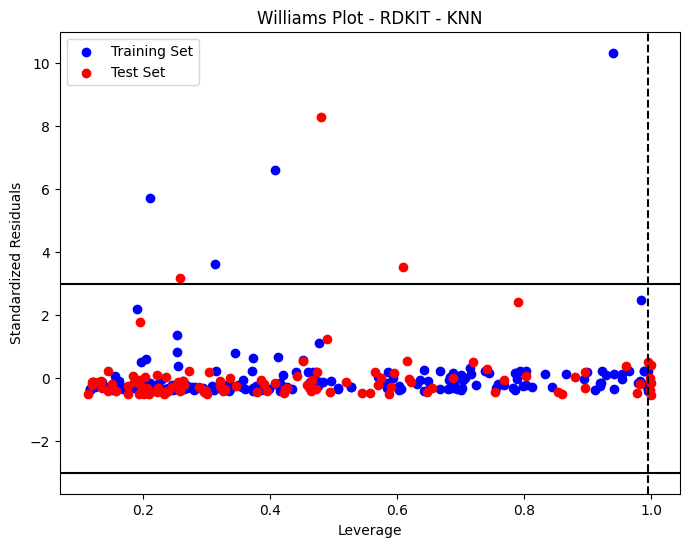



Model: RF


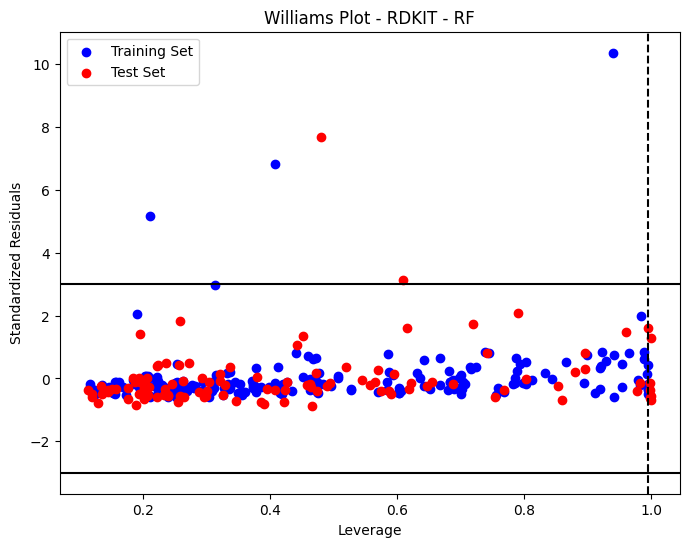



Model: SVR


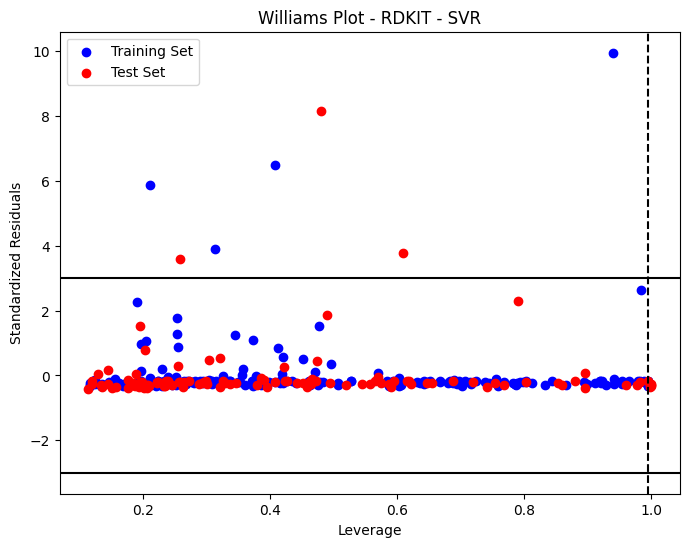




========== Feature Type: ECFP6 ==========
Model: KNN


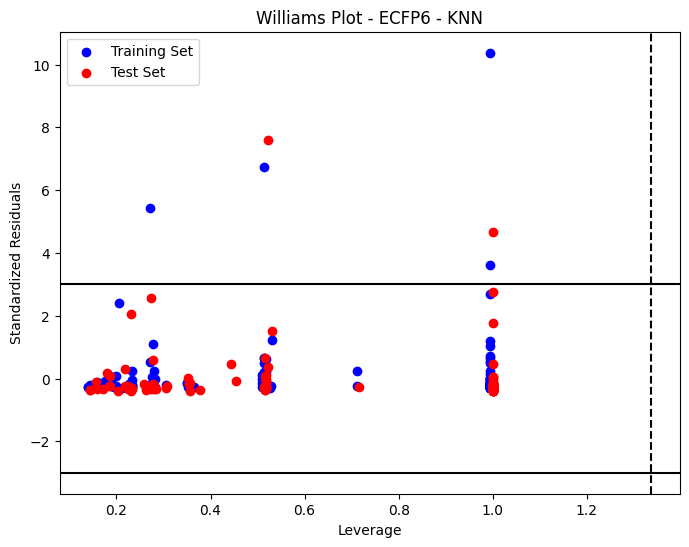



Model: RF


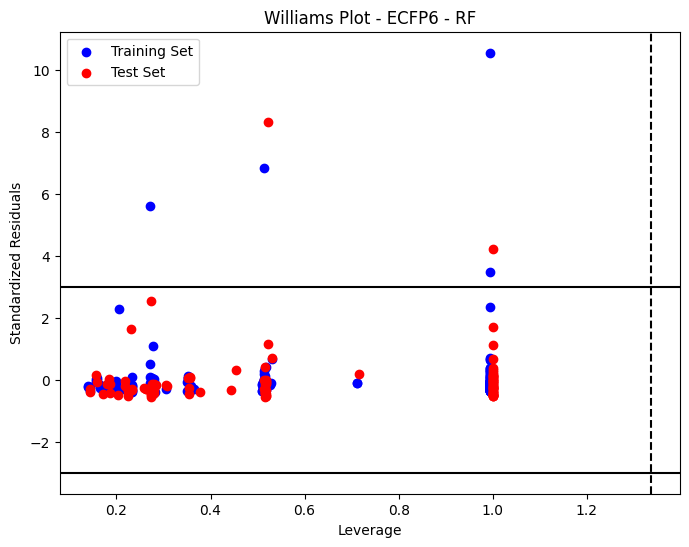



Model: SVR


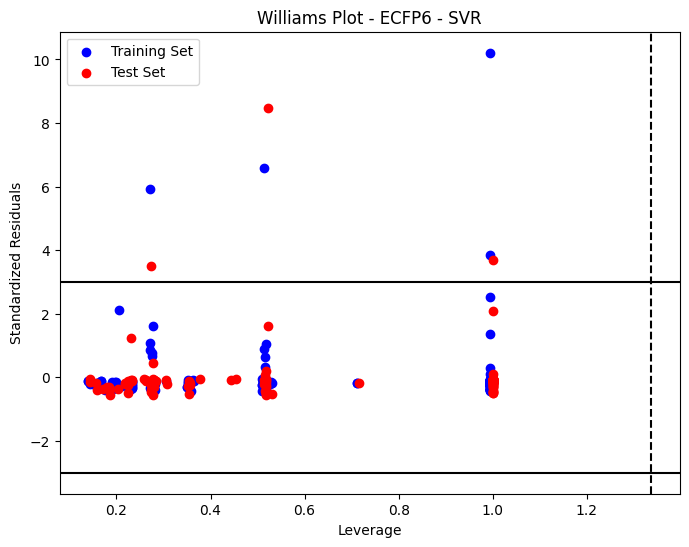




========== Feature Type: FCFP6 ==========
Model: KNN


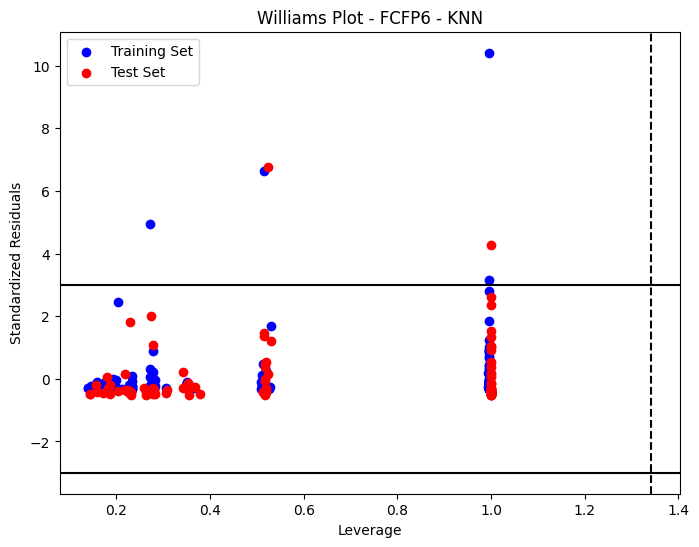



Model: RF


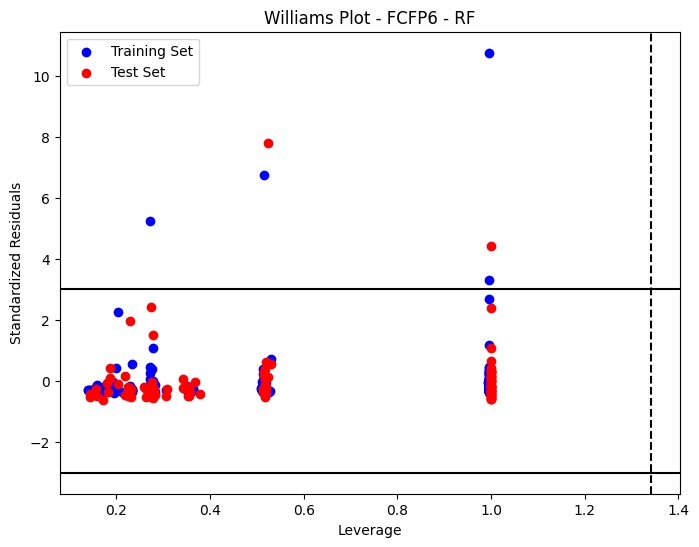



Model: SVR


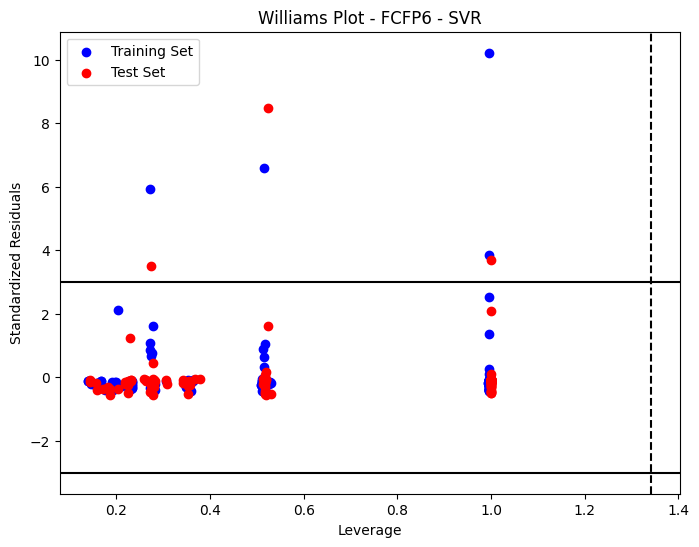




========== Feature Type: MACCS ==========
Model: KNN


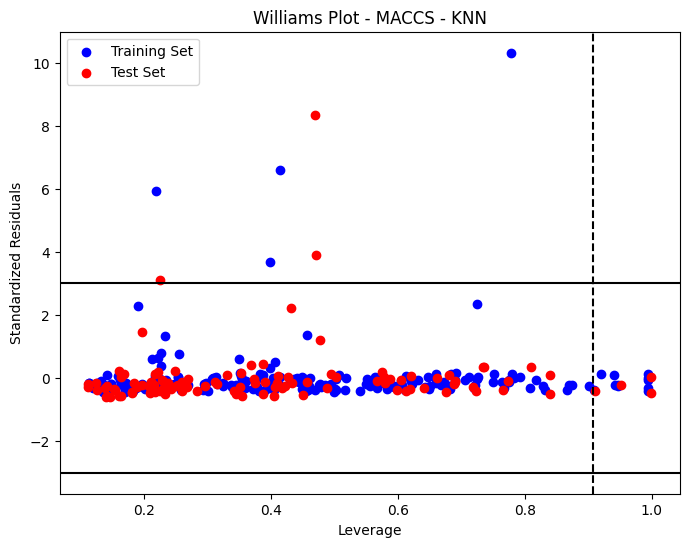



Model: RF


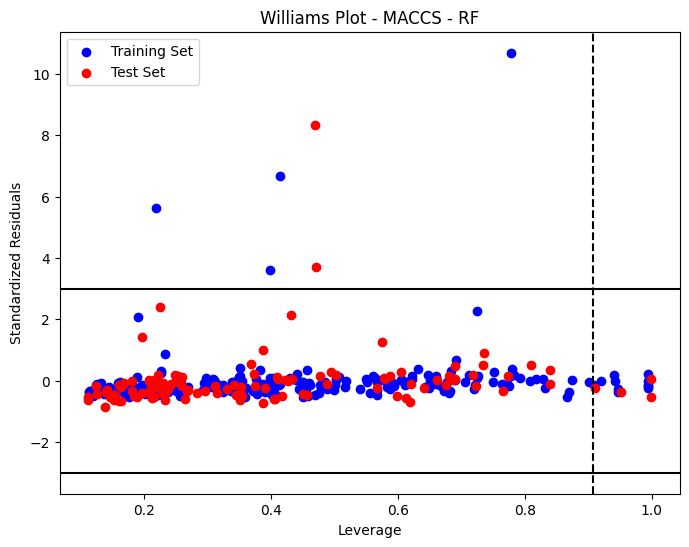



Model: SVR


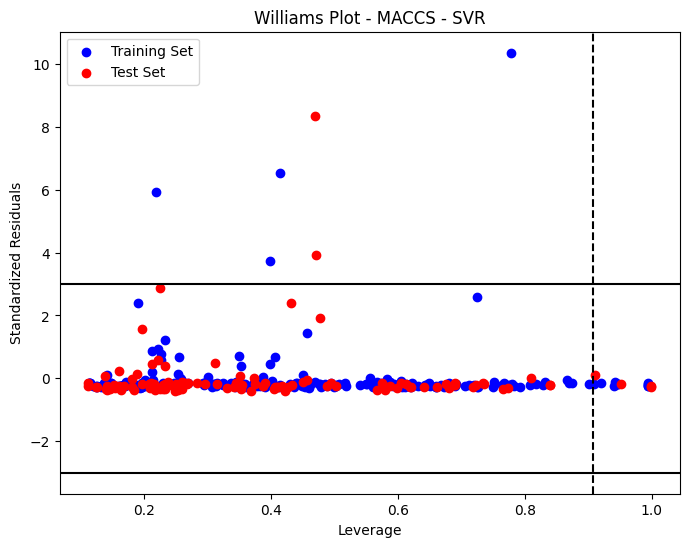




========== Feature Type: All ==========
Model: KNN


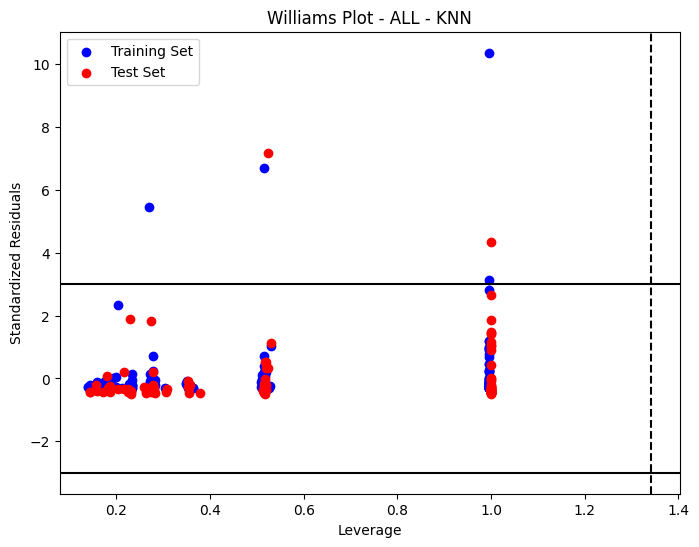



Model: RF


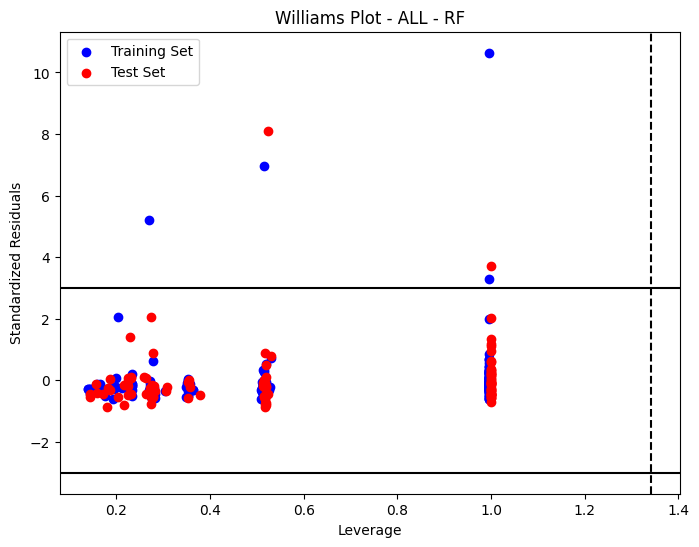



Model: SVR


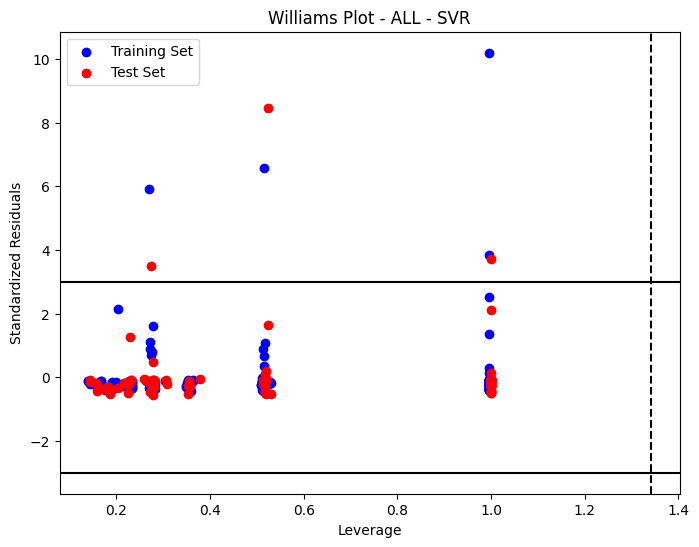

In [ ]:
# Define the applicability domain function
def hat_matrix(X, random_seed=None):
    np.random.seed(random_seed)       # set random state for reproducibility

    xtx = np.dot(X.T, X)
    np.fill_diagonal(xtx, np.diagonal(xtx) + np.random.uniform(0.001, 0.002, size=len(xtx)))
    ixtx = np.linalg.pinv(xtx)
    return np.dot(np.dot(X, ixtx), X.T)

def eval_ad(X_train, X_test, y_train, y_test, model):

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    H_train = hat_matrix(np.vstack((X_train, X_test)), random_seed=2)     # set random state for reproducibility

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    residual_train = np.abs(y_train - y_pred_train)
    residual_test = np.abs(y_test - y_pred_test)
    s_residual_train = (residual_train - np.mean(residual_train)) / np.std(residual_train)
    s_residual_test = (residual_test - np.mean(residual_test)) / np.std(residual_test)

    leverage_train = np.diag(H_train)[:X_train.shape[0]]
    leverage_test = np.diag(H_train)[X_train.shape[0]:]

    p = X_train.shape[1] + 1                # features
    n = X_train.shape[0] + X_test.shape[0]  # total compounds
    h_star = (3 * p) / n

    AD_train = 100 * np.sum((leverage_train < h_star) & (np.abs(s_residual_train) < 3)) / len(leverage_train)
    AD_test = 100 * np.sum((leverage_test < h_star) & (np.abs(s_residual_test) < 3)) / len(leverage_test)

    return AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test

feature_types = ['RDKit', 'ECFP6', 'FCFP6', 'MACCS', 'All']

for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
    print(f"========== Feature Type: {feature_type} ==========")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

    for model_name, (model, _) in models.items():
        print(f"Model: {model_name}")
        best_model, best_params, results, X_train, X_test, y_train, y_test, y_hat_train, y_hat_test = tuning_hyper(X=X, y=y, model_name=model_name)
        AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test = eval_ad(X_train, X_test, y_train, y_test, best_model)

        # Find chemicals exceeding AD area
        train_exceed_AD = (leverage_train > np.mean(leverage_train) + 2 * np.std(leverage_train)) | \
                          (np.abs(s_residual_train) > 3)

        # Create Williams plot for three algorithms: KNN, RF, and SVR with five types of descriptors
        plt.figure(figsize=(8, 6))
        plt.scatter(leverage_train, s_residual_train, c='blue', label='Training Set')
        plt.scatter(leverage_test, s_residual_test, c='red', label='Test Set')
        plt.axhline(y=np.mean(s_residual_train) + 3 * np.std(s_residual_train), color='black', linestyle='-')
        plt.axhline(y=np.mean(s_residual_train) - 3 * np.std(s_residual_train), color='black', linestyle='-')
        plt.axvline(x=np.mean(leverage_train) + 2 * np.std(leverage_train), color='black', linestyle='--')
        plt.xlabel('Leverage')
        plt.ylabel('Standardized Residuals')
        plt.title(f'Williams Plot - {feature_type.upper()} - {model_name}')
        plt.legend()
        plt.show()

        print("\n")

    print("=============================================\n")

# Correlation for KNN, RF, or SVR Models

In [41]:
'''
To comply with the correlation code rules, please avoid using duplicate species columns.
When generating correlation plots for algorithm simulations with all descriptors, kindly make use of the 'X_All_descrs_NS' parameter with only once species columns.
For simulations involving RDKit, ECFP6, FCFP6, or MACCS descriptors, use the corresponding parameters with species columns: 'X_rdkit', 'X_ECFP6', 'X_FCFP6', or 'X_MACCS.'
It's important to note that the parameters 'X_rdkit_NS,' 'X_ECFP6_NS,' 'X_FCFP6_NS,' and 'X_MACCS_NS' exclude species columns.
'''
X_rdkit_NS = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True)], axis = 1)
X_ECFP6_NS = pd.concat([ECFP6_descrs.reset_index(drop=True)], axis = 1)
X_FCFP6_NS = pd.concat([FCFP6_descrs.reset_index(drop=True)], axis = 1)
X_MACCS_NS = pd.concat([MACCS_descrs.reset_index(drop=True)], axis = 1)
X_All_descrs_NS = pd.concat([species_descr, X_rdkit_NS, X_ECFP6_NS, X_FCFP6_NS, X_MACCS_NS], axis=1)

In [ ]:
# Please replace 'X_All_descrs_NS' with either 'X_rdkit', 'X_ECFP6', 'X_FCFP6', or 'X_MACCS.'
# This code adds columns of the observed and corresponding predicted response variables for half-lives of both training and test sets to one descriptor or fingerprint.
X_All_descrs_NS.loc[X_test.index,'y_hat_test'] = y_hat_test
X_All_descrs_NS.loc[X_train.index,'y_hat_train'] = y_hat_train
X_All_descrs_NS.loc[y_test.index,'y_test'] = y_test
X_All_descrs_NS.loc[y_train.index,'y_train'] = y_train

In [ ]:
# Please replace 'model_name' here with either 'KNN', 'RF', or 'SVR'.
# Here, the correlation plot will be generated for only one algorithm with one descriptor or fingerprint at a time.
print("========== SVR ==========")
model_name = 'SVR'
model, _ = models[model_name]
best_model, best_params, results, X_train, X_test, y_train, y_test, y_hat_train, y_hat_test = tuning_hyper(X=X_All_descrs_NS, y=y, model_name=model_name)
print("Best Params:", best_params)
print("Results:", results)
print("\n")

**Plot the correlation for a single algorithm with only one descriptor or fingerprint in both the training and test sets on a single plot**

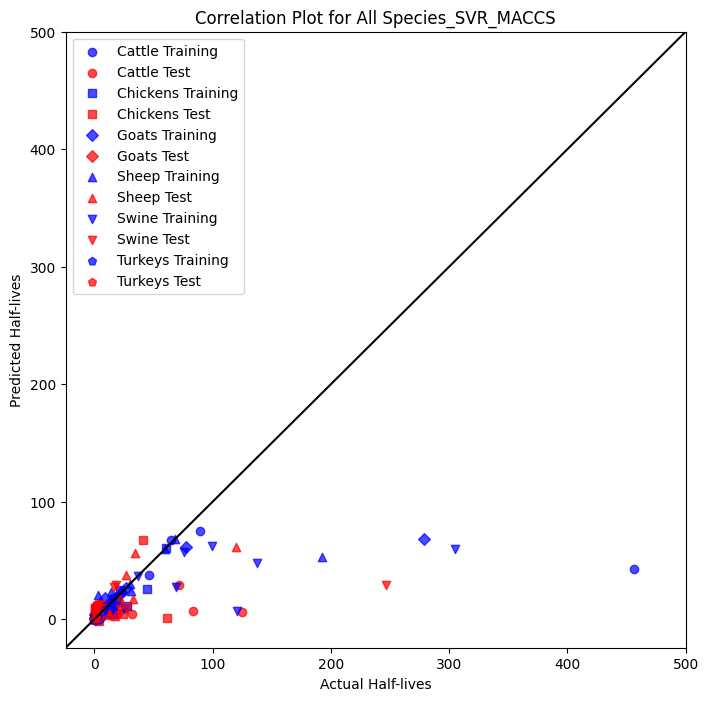

In [ ]:
animal_list = ['Cattle', 'Chickens', 'Goats', 'Sheep', 'Swine', 'Turkeys']

# Initialize lists to store data for all species
all_y_train = []
all_y_train_preds = []
all_y_test = []
all_y_test_preds = []

# Define plotting markers for each species
markers = ['o', 's', 'D', '^', 'v', 'p']

# Create a scatter plot with a line of r=1 for all species
plt.figure(figsize=(8, 8))  # Make the plot square

# Loop through each species and collect data
for idx, animal in enumerate(animal_list):
    # Filter the data for the current species
    species_data = X_MACCS[X_MACCS[animal] == 1]

    # Check if there are any data points left for plotting
    if not species_data.empty:

        # Collect data for training and test sets
        y_train = species_data['y_train']
        y_train_preds = species_data['y_hat_train']
        y_test = species_data['y_test']
        y_test_preds = species_data['y_hat_test']

        # Store data for all species
        all_y_train.extend(y_train)
        all_y_train_preds.extend(y_train_preds)
        all_y_test.extend(y_test)
        all_y_test_preds.extend(y_test_preds)

        # Plot training set data points for the current species in a darker shade
        plt.scatter(y_train, y_train_preds, color='blue', marker=markers[idx], label=f'{animal} Training', alpha=0.7)

        # Plot test set data points for the current species in a lighter shade
        plt.scatter(y_test, y_test_preds, color='red', marker=markers[idx], label=f'{animal} Test', alpha=0.7)

# Calculate the correlation between actual and predicted values for all species
correlation_train = np.corrcoef(all_y_train, all_y_train_preds)[0, 1]
correlation_test = np.corrcoef(all_y_test, all_y_test_preds)[0, 1]

# Calculate min_val based on the specified code
data_range = max(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds) - min(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds)
min_val = min(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds) - 0.05 * data_range

# Set max_val based on the maximum value from the data
max_val = 500

plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='black')

plt.title('Correlation Plot for All Species_SVR_MACCS')
plt.xlabel('Actual Half-lives')
plt.ylabel('Predicted Half-lives')

# Set the limits for both X and Y axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.legend()
plt.show()

# Deep Neural Network Model with Keras

In [18]:
# Install python pacakges
!pip install --upgrade typing-extensions==3.10.0.2  # To address the error of dependency conflicts

!pip install -q scikit-optimize         # Install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]    # Install scikeras package with TensorFlow support
!pip install keras-tuner --upgrade

In [2]:
# Import basic packages for data manipulation, visualization, and machine learning
import numpy as np                                       # Numerical operations
import seaborn as sns                                    # Statistical data visualization
import pandas as pd                                      # Data manipulation and analysis
import tensorflow as tf                                  # Open-source machine learning framework
import os                                                # Operating system functionality
import scikeras                                          # Keras-based interface for scikit-learn
from tensorflow import keras                             # Keras API for building and training neural networks
import matplotlib.pyplot as plt                          # Plotting library
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Toolkit for creating plots with colorbars
import matplotlib.colors as colors                       # Color mapping and normalization
import matplotlib as mpl                                 # Matplotlib library for plotting
import keras_tuner                                       # Hyperparameter tuning library
from numpy.random import seed                            # Seed for reproducibility
import tensorflow                                        # Importing TensorFlow module

# Import Keras-related packages for building neural networks
from tensorflow import keras                             # Keras API for building and training neural networks
from keras.models import Sequential                      # Linear stack of layers for building models
from keras.layers import Dense                           # Fully connected layer
from keras.layers import Dropout                         # Dropout regularization for reducing overfitting
from keras import regularizers                           # Regularization techniques for neural networks
from tensorflow.keras.optimizers import Adam, SGD        # Optimization algorithms
from tensorflow.keras.optimizers.schedules import ExponentialDecay  # Learning rate schedule
from keras.models import load_model                      # Load pre-trained models
from keras.callbacks import EarlyStopping                # Early stopping during model training
from keras_tuner import BayesianOptimization             # Bayesian optimization for hyperparameter tuning
from tensorflow import keras                             # Keras API for building and training neural networks
from tensorflow.keras import layers                      # Keras layers for building models
from keras_tuner import Objective                        # Objective functions for hyperparameter tuning
from tensorflow.keras.optimizers import Adam             # Adam optimizer
from sklearn.metrics import mean_squared_error as mse    # Mean Squared Error metric
from sklearn.model_selection import KFold                # KFold from scikit-learn for cross-validation

In [21]:
def build_model(hp):
  model = Sequential()

  # Input layer
  model.add(Dense(units = hp.Int('dense-bot', min_value=50,
             max_value=1024, step=12, default=50),
             activation = hp.Choice(
                 'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
             input_shape=(X_All_descrs.shape[1],)))


  # Tune the number of units in each dense layer
  for i in range (hp.Int('num_dense_layers',1,3)):
    model.add(Dense(units=hp.Int('dense_'+ str(i), min_value=50, max_value=512, step=25),
          activation = hp.Choice('act_l1',['relu','tanh','sigmoid'])))

  # Tune the droput rate in each dense layer
    model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2, 0.3, 0.5])))


  # add output
  model.add(Dense(1,activation='linear'))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':   # Adaptive Moment Estimation (Adam) is used to optimize the training of deep learning models
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  elif hp_optimizer == 'SGD':  # Stochastic Gradient Descent (SGD) is an optimization algorithm utilized for training deep learning models
     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
     nesterov=True
     momentum=0.9

  model.compile(
    optimizer=hp_optimizer,
    loss='mse',           # default in Keras model
    metrics=['mse'])

  return model

In [22]:
# Check if the model code works correctly
build_model(keras_tuner.HyperParameters())

In [23]:
# seed the random number generator to reproduce the same results
seed(1)
tensorflow.random.set_seed(2)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_All_descrs, y, test_size=0.33, random_state=2)

In [26]:
tuner_bo = BayesianOptimization(
            hypermodel = build_model, # The defined keras-tuner model
            objective = 'val_mse',    # The name of the objective to optimize; 'val_mse' is validation 'mean squared error'
            max_trials = 20,          # the number of combinations of hyperparameters to be tried/executed
            overwrite = True,
            executions_per_trial=3)   # the number of times a single combination has to be executed

tuner_bo.search(X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size = 64,
        epochs = 800, verbose = 0)

In [27]:
# Get the top 2 models
best_params_all=tuner_bo.get_best_hyperparameters()
best_params_all[0].values

{'dense-bot': 362,
 'dense_activation': 'tanh',
 'num_dense_layers': 2,
 'dense_0': 475,
 'act_l1': 'sigmoid',
 'dropout_0': 0.0,
 'Optimizer': 'Adam',
 'learning_rate': 0.0001,
 'dense_1': 350,
 'dropout_1': 0.5,
 'dense_2': 400,
 'dropout_2': 0.5}

In [28]:
# Get the best model from Bayesian Optimization tuning
best_model_all= tuner_bo.get_best_models()[0]

# Display the summary of the best model
best_model_all.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 362)               883280    
                                                                 
 dense_1 (Dense)             (None, 475)               172425    
                                                                 
 dropout (Dropout)           (None, 475)               0         
                                                                 
 dense_2 (Dense)             (None, 350)               166600    
                                                                 
 dropout_1 (Dropout)         (None, 350)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 351       
                                                                 
Total params: 1,222,656
Trainable params: 1,222,656
Non-

In [29]:
# save the model and architecture to a single file in GoogleDrive
best_model_all.save("best_model_all.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
best_model_v2 = load_model('best_model_all.h5')
y_test_preds_v2 = best_model_v2.predict(X_test)
y_train_preds_v2 = best_model_v2.predict(X_train)

# Print R2 and RMSE for both training and test sets
print("\nTest R2 Score: %.2f" %r2_score(y_test, y_test_preds_v2))
print("Train R2 Score: %.2f" %r2_score(y_train, y_train_preds_v2), '\n')

print("Test RMSE: %.2f" %mse(y_test, y_test_preds_v2, squared=False))
print("Train RMSE: %.2f" %mse(y_train, y_train_preds_v2, squared=False))

8/8 [==============================] - 0s 7ms/step

Test R2 Score: 0.58
Train R2 Score: 0.84 

Test RMSE: 19.33
Train RMSE: 17.96


In [31]:
# Estimating the 5-CV R2 and RMSE for the training sets

dnn_best_model = best_model_v2

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
cvr2scores = []
cvrmsescores = []

for train_ix, test_ix in kfold.split(X_train):
  # split data
  X_trian_n, X_test_n = X_train.values[train_ix], X_train.values[test_ix]
  y_trian_n, y_test_n = y_train.values[train_ix], y_train.values[test_ix]
  # create model

  dnn_best_model.fit(X_trian_n,y_trian_n, epochs=600, batch_size=64, verbose=0)
  test_pred = dnn_best_model.predict(X_test_n)
  r2score = r2_score(y_test_n, test_pred)
  rmse   = mse(y_test_n, test_pred,squared=False)

  cvr2scores.append(r2score)
  cvrmsescores.append(rmse)

print("The 5-cv r2 Score was: %.2f (+/-) %.2f" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-cv rmse Score was: %.2f (+/-) %.2f" % (np.mean(cvrmsescores), np.std(cvrmsescores)))

2/2 [==============================] - 0s 9ms/step
The 5-cv r2 Score was: 0.93 (+/-) 0.14
The 5-cv rmse Score was: 7.09 (+/-) 7.55


# Applicability Domain for DNN Model

4/4 [==============================] - 0s 10ms/step


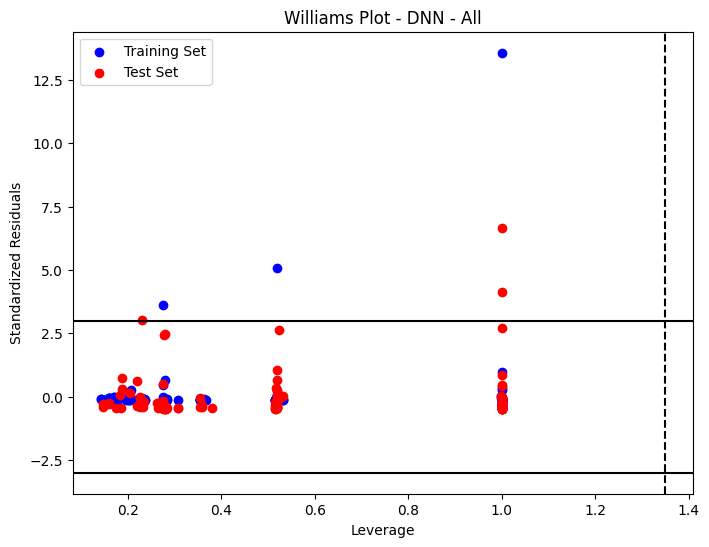

In [45]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the best DNN model from the BayesianOptimization search
best_model_all = load_model("best_model_all.h5")

def hat_matrix(X):
    xtx = np.dot(X.T, X)
    np.fill_diagonal(xtx, np.diagonal(xtx) + np.random.uniform(0.001, 0.002, size=len(xtx)))
    ixtx = np.linalg.pinv(xtx)
    return np.dot(np.dot(X, ixtx), X.T)

# Define the applicability domain function for DNN
def eval_ad_dnn(X_train, X_test, y_train, y_test, model):

    # Get predictions from the DNN model
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Reshape y_train and y_pred_train to 1-dimensional arrays
    y_train = y_train.to_numpy().reshape(-1)
    y_pred_train = y_pred_train.reshape(-1)
    y_pred_train = y_pred_train.reshape(-1)
    y_pred_test = y_pred_test.reshape(-1)

    residual_train = np.abs(y_train - y_pred_train)
    residual_test = np.abs(y_test - y_pred_test)
    s_residual_train = (residual_train - np.mean(residual_train)) / np.std(residual_train)
    s_residual_test = (residual_test - np.mean(residual_test)) / np.std(residual_test)

    H_train = hat_matrix(np.vstack((X_train, X_test)))

    leverage_train = np.diag(H_train)[:X_train.shape[0]]
    leverage_test = np.diag(H_train)[X_train.shape[0]:]

    p = X_train.shape[1] + 1  # features
    n = X_train.shape[0] + X_test.shape[0]  # total compounds
    h_star = (3 * p) / n

    AD_train = 100 * np.sum((leverage_train < h_star) & (np.abs(s_residual_train) < 3)) / len(leverage_train)
    AD_test = 100 * np.sum((leverage_test < h_star) & (np.abs(s_residual_test) < 3)) / len(leverage_test)

    return AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_All_descrs, y, test_size=0.33, random_state=2)

# Evaluate applicability domain for the best DNN model
AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test = eval_ad_dnn(X_train, X_test, y_train, y_test, best_model_all)

# Find chemicals exceeding AD area
train_exceed_AD = (leverage_train > np.mean(leverage_train) + 2 * np.std(leverage_train)) | \
                  (np.abs(s_residual_train) > 3)

test_exceed_AD = (leverage_test > np.mean(leverage_test) + 2 * np.std(leverage_test)) | \
                 (np.abs(s_residual_test) > 3)

# Create Williams plot for DNN model
plt.figure(figsize=(8, 6))
plt.scatter(leverage_train, s_residual_train, c='blue', label='Training Set')
plt.scatter(leverage_test, s_residual_test, c='red', label='Test Set')
plt.axhline(y=np.mean(s_residual_train) + 3 * np.std(s_residual_train), color='black', linestyle='-')
plt.axhline(y=np.mean(s_residual_train) - 3 * np.std(s_residual_train), color='black', linestyle='-')
plt.axvline(x=np.mean(leverage_train) + 2 * np.std(leverage_train), color='black', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Williams Plot - DNN - All')
plt.legend()
plt.show()

# Adjust indices for the original training set
train_exceed_indices_original = np.where(train_exceed_AD)[0]
train_exceed_indices_original[train_exceed_indices_original < X_train.shape[0]]

# Adjust indices for the original test set
test_exceed_indices_original = np.where(test_exceed_AD)[0]
test_exceed_indices_original[test_exceed_indices_original < X_test.shape[0]]

# Get the actual chemicals
train_exceed_chemicals = X_train.iloc[train_exceed_indices_original]
test_exceed_chemicals = X_test.iloc[test_exceed_indices_original]

In [33]:
# Get the actual chemicals that exceed the AD in the training sets
train_exceed_chemicals

,Cattle,Chickens,Goats,Sheep,Swine,Turkeys,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
45,0,0,0,0,1,0,0.358973,0.646804,0.358973,0.075573,...,1,0,1,1,1,1,1,1,1,0
271,1,0,0,0,0,0,0.545158,0.332360,0.545158,0.043824,...,0,1,0,0,1,1,1,0,1,0
167,0,0,1,0,0,0,0.711905,0.235508,0.711905,0.783358,...,1,0,1,1,0,0,1,1,1,0


In [34]:
# Get the actual chemicals that exceed the AD in the test sets
test_exceed_chemicals

,Cattle,Chickens,Goats,Sheep,Swine,Turkeys,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
178,1,0,0,0,0,0,0.089090,0.474959,0.089090,1.000000,...,1,0,1,0,0,0,1,1,1,0
234,1,0,0,0,0,0,0.552112,0.352805,0.552112,0.633899,...,1,0,1,1,0,0,1,1,1,0
29,0,1,0,0,0,0,0.481243,0.589973,0.481243,0.109555,...,1,1,1,1,1,1,1,1,1,0


# Correlation for DNN Model

In [42]:
# Please replace 'X_All_descrs_NS' with either 'X_rdkit', 'X_ECFP6', 'X_FCFP6', or 'X_MACCS.'
# This code adds columns of the observed and corresponding predicted response variables for half-lives of both training and test sets to one descriptor or fingerprint.
X_All_descrs_NS.loc[X_test.index,'y_test_preds'] = y_test_preds_v2
X_All_descrs_NS.loc[X_train.index,'y_train_preds'] = y_train_preds_v2
X_All_descrs_NS.loc[y_test.index,'y_test'] = y_test
X_All_descrs_NS.loc[y_train.index,'y_train'] = y_train

**Plot the correlation for all species using only one descriptor or fingerprint in both the training and test sets on a single plot**

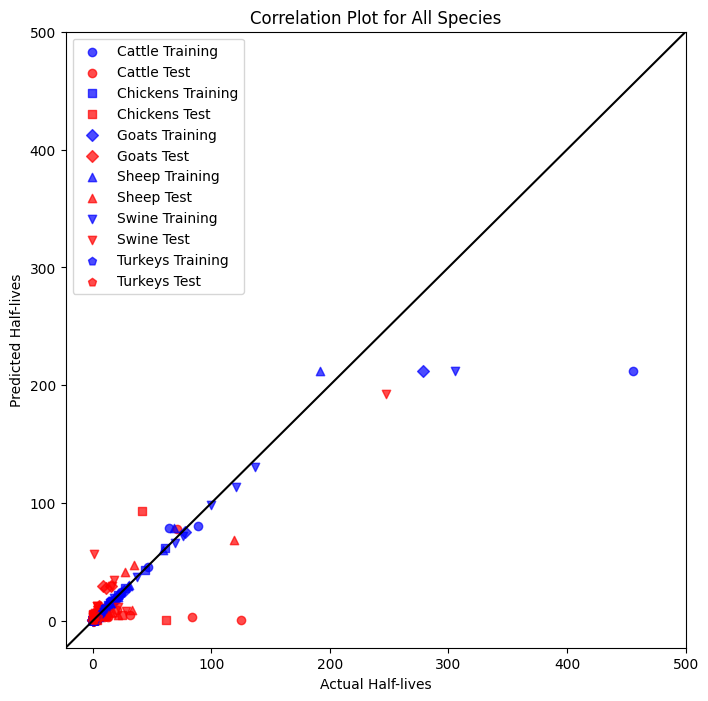

In [43]:
animal_list = ['Cattle', 'Chickens', 'Goats', 'Sheep', 'Swine', 'Turkeys']

# Initialize lists to store data for all species
all_y_train = []
all_y_train_preds = []
all_y_test = []
all_y_test_preds = []

# Define plotting markers for each species
markers = ['o', 's', 'D', '^', 'v', 'p']

# Create a scatter plot with a line of r=1 for all species
plt.figure(figsize=(8, 8))  # Make the plot square

# Loop through each species and collect data
for idx, animal in enumerate(animal_list):
    # Filter the data for the current species
    species_data = X_All_descrs_NS[X_All_descrs_NS[animal] == 1]

    # Check if there are any data points left for plotting
    if not species_data.empty:
        # Collect data for training and test sets
        y_train = species_data['y_train']
        y_train_preds = species_data['y_train_preds']
        y_test = species_data['y_test']
        y_test_preds = species_data['y_test_preds']

        # Store data for all species
        all_y_train.extend(y_train)
        all_y_train_preds.extend(y_train_preds)
        all_y_test.extend(y_test)
        all_y_test_preds.extend(y_test_preds)

        # Plot training set data points for the current species in a darker shade
        plt.scatter(y_train, y_train_preds, color='blue', marker=markers[idx], label=f'{animal} Training', alpha=0.7)

        # Plot test set data points for the current species in a lighter shade
        plt.scatter(y_test, y_test_preds, color='red', marker=markers[idx], label=f'{animal} Test', alpha=0.7)

# Calculate the correlation between actual and predicted values for all species
correlation_train = np.corrcoef(all_y_train, all_y_train_preds)[0, 1]
correlation_test = np.corrcoef(all_y_test, all_y_test_preds)[0, 1]

# Calculate min_val based on the specified code
data_range = max(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds) - min(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds)
min_val = min(all_y_train + all_y_train_preds + all_y_test + all_y_test_preds) - 0.05 * data_range

# Set max_val based on the maximum value from the data
max_val = 500

plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='black')

plt.title('Correlation Plot for All Species')
plt.xlabel('Actual Half-lives')
plt.ylabel('Predicted Half-lives')

# Set the limits for both X and Y axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.legend()
plt.show()